In [16]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

project_dir = str(os.path.dirname((os.path.abspath(''))))
sys.path.append(project_dir)
print(project_dir)
figures_folder = project_dir + '/reports/figures/'



from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from src.data.pickle_util import save_pickle, load_pickle

import  datetime

import math

import seaborn as sns

/Users/erik/metis/spotipy_hits


# Load data

## Load dataframe from csv: merged spotify and rolling stone data

In [17]:
base_path = project_dir + '/data/processed/'
file_name = 'df_spot_rs_merge_basic.csv'
print(base_path + file_name)
df_spot_rs_merge = pd.read_csv(base_path + file_name)
df_spot_rs_merge = df_spot_rs_merge.drop(['Unnamed: 0'], axis=1)

/Users/erik/metis/spotipy_hits/data/processed/df_spot_rs_merge_basic.csv


# Analysis: Distributions

inspect df

In [18]:
df_spot_rs_merge

,year_rank_score,year_album_units,avg_vol,total_tracks,duration,release_date,record_label,title_cleaned,caption_artist,album_id
0,134,12.7,-9.584857,14.0,2418639.0,1.565932e+09,other,"- Ugh, those feels again",Snoh Aalegra,42wtqDcTQlJJbUzAPBSwaK
1,48,5.9,-6.726071,14.0,3100819.0,1.333429e+09,other,10 Day,Chance The Rapper,6bUsvxMAuR8NXG2ujCU4yi
2,306,38.1,-12.741000,11.0,4550970.0,1.146200e+09,other,"10,000 Days",Tool,1fvWYcbjuycyHpzNPH1Vfk
3,25,5.3,-3.787812,16.0,3114311.0,1.558069e+09,other,11:11,Maluma,3YIUNL7qFE8NP3X3zaYSND
4,6484,408.4,-15.489545,11.0,1319918.0,1.503637e+09,other,17,XXXTentacion,5VdyJkLe3yvOs0l4xXbWp0
...,...,...,...,...,...,...,...,...,...,...
595,9394,822.7,-6.622000,12.0,2470209.0,1.549606e+09,Republic,"thank u, next",Ariana Grande,2fYhqwDWXjbpjaIJPEfKFw
596,47,5.6,-6.742455,11.0,2022586.0,1.570165e+09,other,uknowhatimsayin¿,Danny Brown,4G3BRVsGEpWzUdplFJ1VBl
597,2452,267.5,-7.248933,15.0,3236579.0,1.545545e+09,Atlantic Records,x,Ed Sheeran,7CjJb2mikwAWA1V6kewFBF
598,271,27.8,-3.707500,14.0,2827025.0,1.571980e+09,other,Épico,Lunay,46xbsFOp9g1WqTidQEs7YT


## distribution of year_album_units
Look at distribution of year_album_units

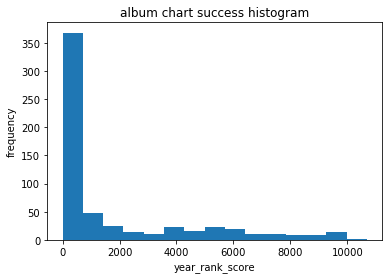

In [19]:
x = df_spot_rs_merge.year_rank_score
plt.hist(x, bins=15)
plt.xlabel('year_rank_score')
plt.ylabel('frequency')
plt.title('album chart success histogram')
file_path = figures_folder + 'Album_chart_success_histogram_1.svg'
plt.savefig(file_path, format='svg')
pass

There's a wide spread, but most are comparitively low year_rank_score. 

## distribution of log(year_album_units)

Try viewing the log of year_rank_score

In [20]:
def format_title(s):
    return s.replace(' ', '_').lower()

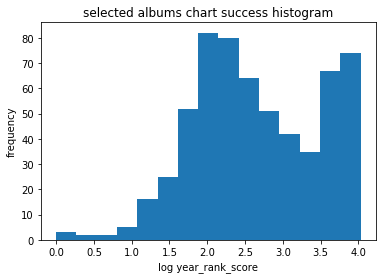

In [21]:
x = np.log10(df_spot_rs_merge.year_rank_score)
plt.hist(x, bins=15)
plt.xlabel('log year_rank_score')
plt.ylabel('frequency')
title = 'selected albums chart success histogram'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

That's better.   
So: most have around 200 points, while a about 150 have close to 10,000 points

## Add log_score to df
Add log_score to df

In [22]:
df_spot_rs_merge['log_score'] = np.log10(df_spot_rs_merge['year_rank_score'])

And rearrange columns

In [23]:
df_spot_rs_merge = df_spot_rs_merge[['year_rank_score', 'log_score', 'year_album_units', 'avg_vol', 'total_tracks',
       'duration', 'release_date', 'record_label', 'title_cleaned',
       'caption_artist', 'album_id']]

Inspect df

In [24]:
df_spot_rs_merge

,year_rank_score,log_score,year_album_units,avg_vol,total_tracks,duration,release_date,record_label,title_cleaned,caption_artist,album_id
0,134,2.127105,12.7,-9.584857,14.0,2418639.0,1.565932e+09,other,"- Ugh, those feels again",Snoh Aalegra,42wtqDcTQlJJbUzAPBSwaK
1,48,1.681241,5.9,-6.726071,14.0,3100819.0,1.333429e+09,other,10 Day,Chance The Rapper,6bUsvxMAuR8NXG2ujCU4yi
2,306,2.485721,38.1,-12.741000,11.0,4550970.0,1.146200e+09,other,"10,000 Days",Tool,1fvWYcbjuycyHpzNPH1Vfk
3,25,1.397940,5.3,-3.787812,16.0,3114311.0,1.558069e+09,other,11:11,Maluma,3YIUNL7qFE8NP3X3zaYSND
4,6484,3.811843,408.4,-15.489545,11.0,1319918.0,1.503637e+09,other,17,XXXTentacion,5VdyJkLe3yvOs0l4xXbWp0
...,...,...,...,...,...,...,...,...,...,...,...
595,9394,3.972851,822.7,-6.622000,12.0,2470209.0,1.549606e+09,Republic,"thank u, next",Ariana Grande,2fYhqwDWXjbpjaIJPEfKFw
596,47,1.672098,5.6,-6.742455,11.0,2022586.0,1.570165e+09,other,uknowhatimsayin¿,Danny Brown,4G3BRVsGEpWzUdplFJ1VBl
597,2452,3.389520,267.5,-7.248933,15.0,3236579.0,1.545545e+09,Atlantic Records,x,Ed Sheeran,7CjJb2mikwAWA1V6kewFBF
598,271,2.432969,27.8,-3.707500,14.0,2827025.0,1.571980e+09,other,Épico,Lunay,46xbsFOp9g1WqTidQEs7YT


## Distribution of average album volume

look at distribution of average album volume.

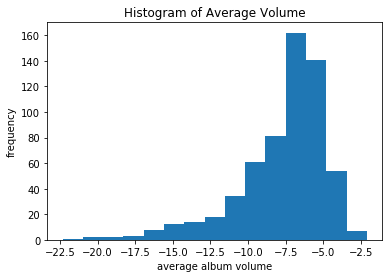

In [25]:
x = df_spot_rs_merge.avg_vol
plt.hist(x, bins=15)
plt.xlabel('average album volume')
plt.ylabel('frequency')
plt.title('')
title = 'Histogram of Average Volume'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

## Distribution of total number of tracks

Look at distribution of number of tracks

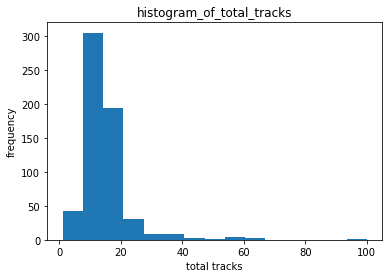

In [26]:
x = df_spot_rs_merge.total_tracks
plt.hist(x, bins=15)
plt.xlabel('total tracks')
plt.ylabel('frequency')
title = 'histogram_of_total_tracks'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

For now, drop albums with total_tracks above 30, so we can see most of them in more detail

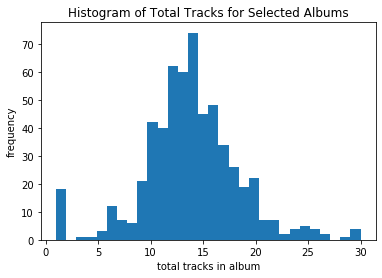

In [28]:
df = df_spot_rs_merge.loc[df_spot_rs_merge.total_tracks <= 30]
df.total_tracks
plt.hist(df.total_tracks, bins = 30)
plt.ylabel('frequency')
plt.xlabel('total tracks in album')
title = 'Histogram of Total Tracks for Selected Albums'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

Many albums have 14 tracks, and most seem to be between 10 and 20.

## distribution of album duration
Look at distribution of album duration

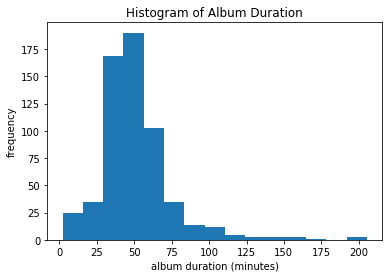

In [29]:
x = df_spot_rs_merge.duration/1000 / 60
plt.hist(x, bins=15)
plt.xlabel('album duration (minutes)')
plt.ylabel('frequency')
title = 'Histogram of Album Duration'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

Most albums around around 50 minutes.

Let's take a closer look at those between 20 and 80 minutes

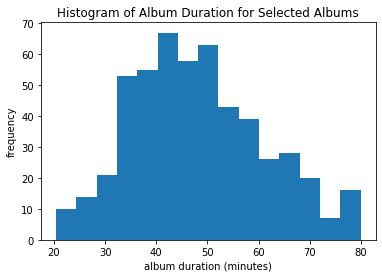

In [30]:
duration = df_spot_rs_merge.duration/1000 / 60
x = duration[(duration >= 20) & (duration <= 80)]
plt.hist(x, bins=15)
plt.xlabel('album duration (minutes)')
plt.ylabel('frequency')
title = 'Histogram of Album Duration for Selected Albums'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

So Most are between 35 and 60 minutes

## Distribution of release date

Let's look at the distribution of release dates

/Users/erik/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


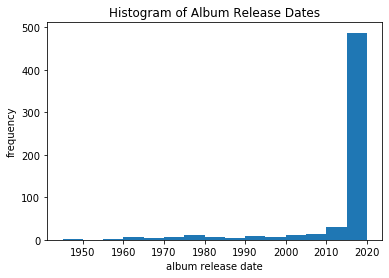

In [31]:
x = pd.to_datetime(df_spot_rs_merge['release_date'], unit='s')


plt.hist(x, bins=15)
plt.xlabel('album release date')
plt.ylabel('frequency')
title = 'Histogram of Album Release Dates'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

That's nearly all between 2015 and 2020. Let's look at the decade to 2020

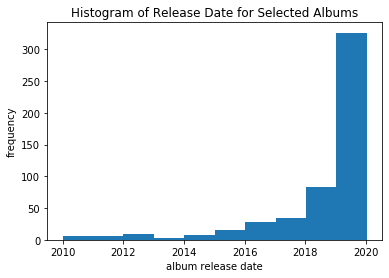

In [32]:
ser = pd.to_datetime(df_spot_rs_merge['release_date'], unit='s')
x = ser[ser > pd.to_datetime(2010, format='%Y')]
plt.hist(x, bins=10)
plt.xlabel('album release date')
plt.ylabel('frequency')
title = 'Histogram of Release Date for Selected Albums'
plt.title(title)
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

It's still nearly all in 2019. Let's look just at year 2019 onwards

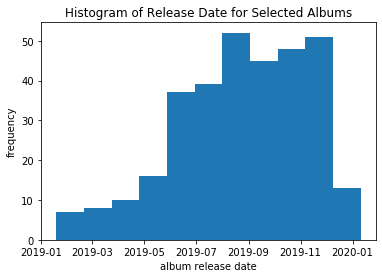

In [33]:
ser = pd.to_datetime(df_spot_rs_merge['release_date'], unit='s')
x = ser[(ser > pd.to_datetime(2019, format='%Y'))] # & (ser < pd.to_datetime(2020, format='%Y'))]
plt.hist(x, bins=11)
plt.xlabel('album release date')
plt.ylabel('frequency')
title = 'Histogram of Release Date for Selected Albums'
plt.title(title)
title += '_2'
file_path = figures_folder + format_title(title) + '.svg'
plt.savefig(file_path, format='svg')
pass

It appears that albums released later in the year have more success.

# Analysis: Pair Plot

Let's draw a pair plot for selected data in df_spot_rs_merge

In [18]:
df_spot_rs_merge.columns

Index(['year_rank_score', 'log_score', 'year_album_units', 'avg_vol',
       'total_tracks', 'duration', 'release_date', 'record_label',
       'title_cleaned', 'caption_artist', 'album_id'],
      dtype='object')

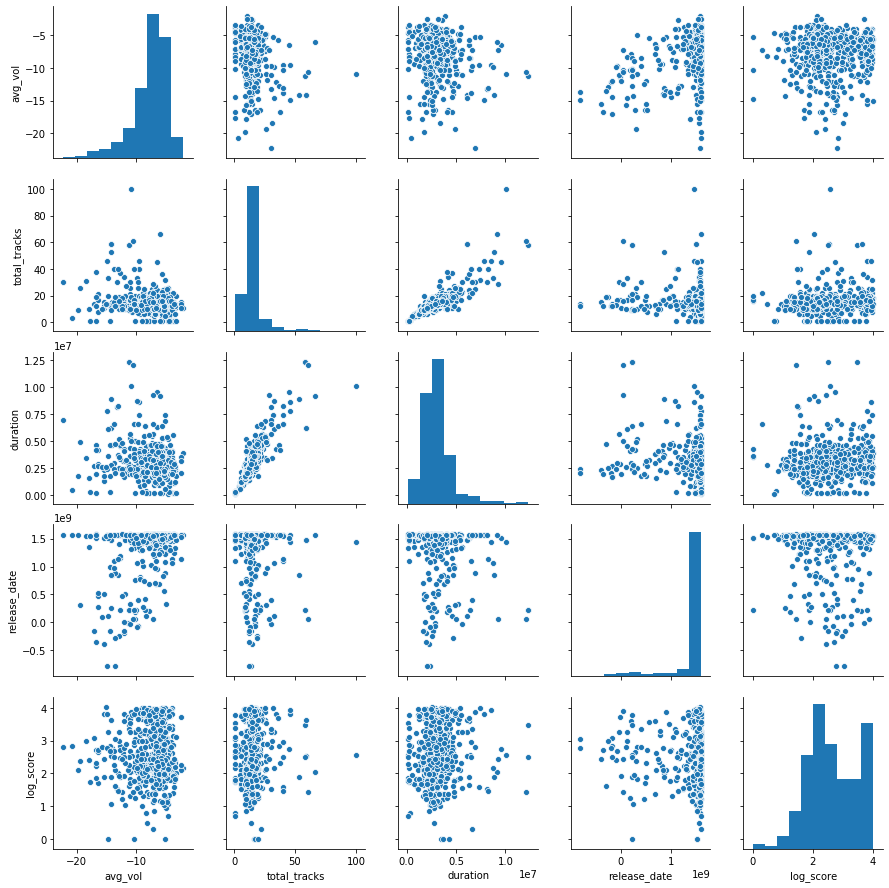

In [37]:
import seaborn as sns
df = df_spot_rs_merge[['avg_vol', 'total_tracks','duration', 'release_date', 'log_score']]
# sns.pairplot(df)
sns_plot = sns.pairplot(df)
sns_plot.savefig(figures_folder + 'pair_plot_1.svg')

Try it with only the tracks released from 2019 onwardrs

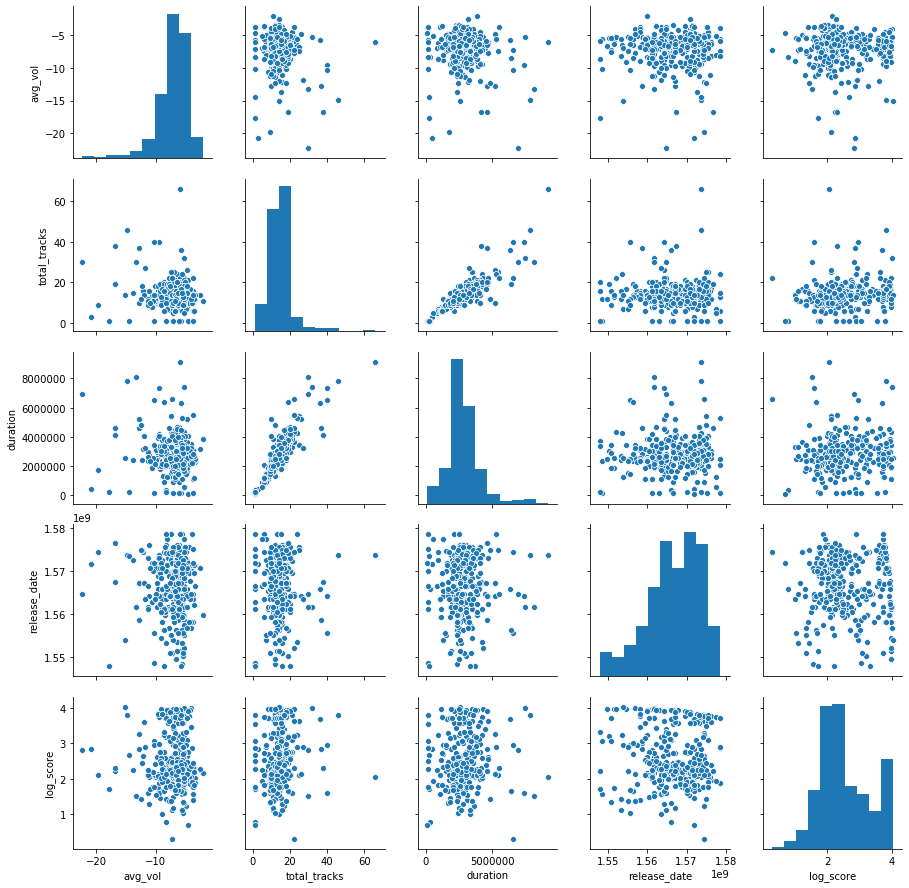

In [20]:

df = df_spot_rs_merge[['avg_vol', 'total_tracks','duration', 'release_date', 'log_score']].copy()
df['release_date_datetime'] = (pd.to_datetime(df['release_date'], unit='s'))
df = df[df['release_date_datetime'] > pd.to_datetime(2019, format='%Y')]
sns.pairplot(df)
# df.columns

# Analysis: alpha for density of scatter plot of 

Look at the scatter plot for total tracks in album and log score. Set alpha rather low, to see if we can get some insight from the density of points

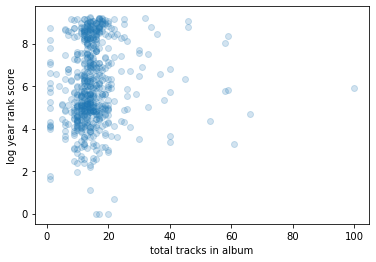

In [21]:
plt.scatter(df_spot_rs_merge.total_tracks, np.log(df_spot_rs_merge.year_rank_score), alpha = .2)
plt.xlabel('total tracks in album')
plt.ylabel('log year rank score')
pass

Doesn't look like much here, but let's focus on ones with fewer that 30 tracks

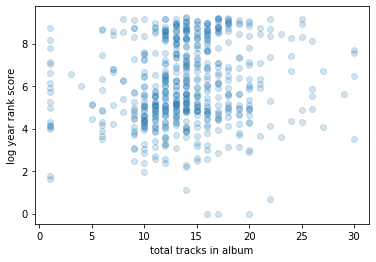

In [22]:
df = df_spot_rs_merge.loc[df_spot_rs_merge.total_tracks <= 30]
plt.scatter(df.total_tracks, np.log(df.year_rank_score), alpha = .2)
plt.xlabel('total tracks in album')
plt.ylabel('log year rank score')
pass

Looks neat, but doesn't look linear. Looks like a blob.

# Analysis: value counts of record label

Let's look at the record label column, and see how many albums ap9pear for each record label

In [23]:
df_spot_rs_merge.record_label.value_counts()

other               401
Interscope           57
Atlantic Records     32
Columbia Records     31
Republic             27
RCA Records          26
Capitol              26
Name: record_label, dtype: int64

oops, these data have already had record label converted to 'other' for everything other than the major 6.  
I'll pull from a pickle to get the data with record labels intact

In [27]:
file_path = project_dir + '/data/interim/' + 'merge_of_rs_and_spotify_with_all_record_labels'
df_record_labels = load_pickle(file_path)

In [53]:
df_record_labels.record_label.value_counts(dropna=False).head(10)

NaN                 97
Interscope          57
Atlantic Records    32
Columbia Records    31
Republic            27
Capitol             26
RCA Records         26
Epic Records        18
Def Jam             14
Warner Bros.        11
Name: record_label, dtype: int64

In [54]:
df_record_labels.record_label.value_counts(dropna=False).tail(10)

Heavy On The Grind Entertainment    1
Virgin                              1
K-TEL                               1
OVO                                 1
Boys Don't Cry                      1
Hoodie Allen                        1
Caroline International              1
Atlantic Records Nashville          1
XL Recordings                       1
Kemosabe Records/RCA                1
Name: record_label, dtype: int64

A relatively small number of record labels seem to have most of the albums. Let's look at this

In [59]:
df_record_labels.record_label.value_counts(dropna=False).value_counts().sort_index()

1     78
2     24
3     14
4      5
5      4
6      2
7      2
9      3
11     1
14     1
18     1
26     2
27     1
31     1
32     1
57     1
97     1
Name: record_label, dtype: int64

Here, the index is the number a records a record label has, and the values are the number of record labels with that number of records. Clearly, most record labels have 1, 2, or 3 albums. Only 6 have more than 25. (The 97 is for NaN values)

# Conclusion: Modelling with Linear Regression is not usefull here

Based on the above, and additional experiments on running linear regression models on these data, I conclude that attempting to run this data through a linear model would not be profitable.